## Modelo para Predição de Correntes de Fuga em Isoladores de Distribuição
#### Rafael Henrique Pinotti 

### Problema

A qualidade no fornecimento de energia elétrica é uma preocupação constante das concessionárias, e um dos grandes problemas são falhas na transmissão e distribuição desta energia às unidades consumidoras.

Por estarem, normalmente, expostas às condições ambientais, as linhas de distribuição e transmissão de energia sofrem ação de agentes atmosféricos a todo o momento.

Um dos mais importantes equipamentos presente nas linhas são os isoladores elétricos, que têm a função de limitar a passagem de corrente elétrica permitindo a operação de forma segura de dispositivos e sistemas elétricos.

As falhas em isoladores elétricos são responsáveis por muitos desligamentos (não programados) na rede elétrica, e o monitoramento da saúde destes equipamentos permite uma manutenção preventiva mais eficiente.

Os dados coletados são provenientes da Dissertação de Mestrado de Milton Augusto Pinotti, defendida na Universidade Regional de Blumenau (Furb).

Pretende-se com esta análise encontrar um modelo para predição da corrente de fuga em isoladores elétricos, permitindo uma ação preventiva mais eficiente para este tipo de equipamento em sistemas de transmissão e distribuição de energia elétrica.

Os dados analisados foram coletados em uma EMSI (Estação de Monitoramento de Sistemas Isolantes) instalada em subestação elétrica da Celesc (Centrais Elétricas de Santa Catarina) na Praia Brava em Itajaí/SC.

Os dados foram coletados diariamente durante o mês de Fevereiro de 2010, totalizando 40.320 registros em cada um dos 40 sistemas isolantes, realizando a medição das correntes de fuga e das condições atmosféricas no período.

Neste artigo trabalharemos com apenas um dos isoladores.

### Criação do Modelo

#### Importação das Bibliotecas e Configurações Globais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Aquisição dos dados

In [2]:
# Importar dados de arquivo csv, onde o separador de campos é '.' e o separador de casas decimais é ','
df = pd.read_csv('dados/dados_isolador40.csv', sep=';', decimal=',')

#### Análise exploratória dos dados

In [3]:
df.head(5)

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
0,70,29.6,1016,278,1.4,0,0.024992
1,69,29.7,1016,297,1.4,0,0.022767
2,70,29.8,1016,273,1.6,0,0.022607
3,68,29.8,1016,243,2.6,0,0.022426
4,68,29.7,1016,257,2.8,0,0.031797


In [4]:
# formato do dataframe (registros/colunas)
df.shape

(40316, 7)

In [5]:
display(df.columns.values)

array(['umidade', 'temperatura', 'pressao', 'vento_ang', 'vent_veloc',
       'chuva', 'corrente_fuga'], dtype=object)

In [6]:
# Valores missing
df.isnull().any()

umidade          False
temperatura      False
pressao          False
vento_ang        False
vent_veloc       False
chuva            False
corrente_fuga    False
dtype: bool

In [7]:
# Registros nulos
df.isnull().sum()

umidade          0
temperatura      0
pressao          0
vento_ang        0
vent_veloc       0
chuva            0
corrente_fuga    0
dtype: int64

In [8]:
# Quantidade de registros com valor zero em cada atributo.
(df == 0).sum()

umidade              0
temperatura          0
pressao              0
vento_ang           92
vent_veloc       14511
chuva            38064
corrente_fuga        0
dtype: int64

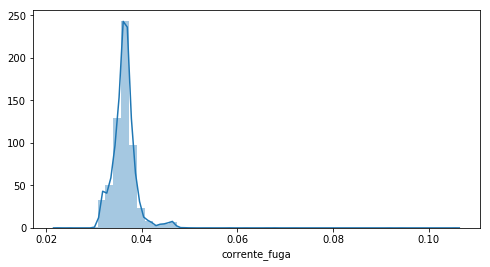

In [9]:
plt.figure(figsize=(8,4))
plt.tight_layout()
sns.distplot(df.corrente_fuga);

In [10]:
def distplots_dataframe(df_analisado):
    fig, ax = plt.subplots(3, 3, figsize=(14,8))
    #fig, ax = plt.subplots(1, 1, figsize=(14,8))
    fig.tight_layout(pad=3.0)

    sns.distplot(df_analisado.umidade, ax=ax[0,0])
    sns.distplot(df_analisado.temperatura, ax=ax[0,1])
    sns.distplot(df_analisado.pressao, ax=ax[0,2])
    sns.distplot(df_analisado.vento_ang, ax=ax[1,0])
    sns.distplot(df_analisado.vent_veloc, ax=ax[1,1])
    sns.distplot(df_analisado.chuva, ax=ax[1,2])
    sns.distplot(df_analisado.corrente_fuga, ax=ax[2,0])

    plt.show()

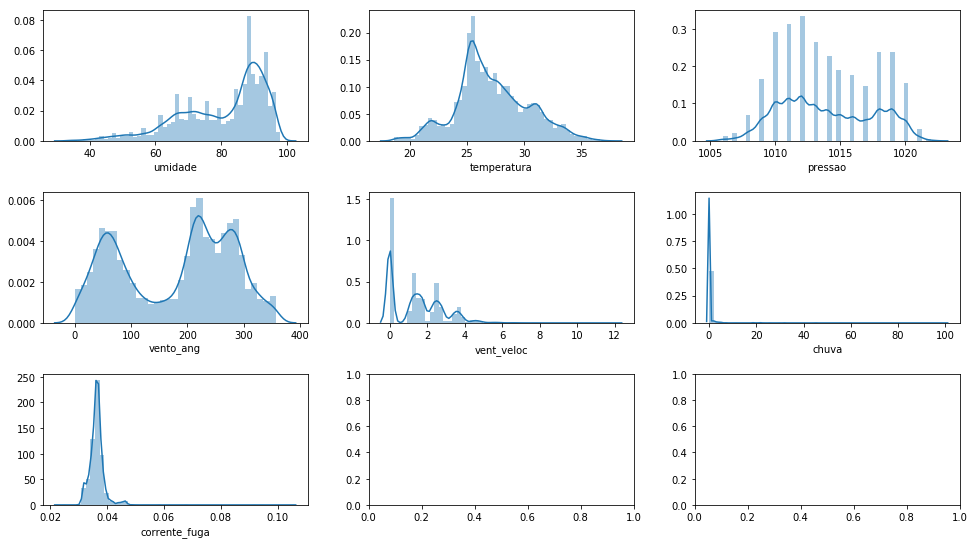

In [11]:
distplots_dataframe(df)

In [12]:
min_scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = pd.DataFrame(min_scaler.fit_transform(df), columns=df.columns)

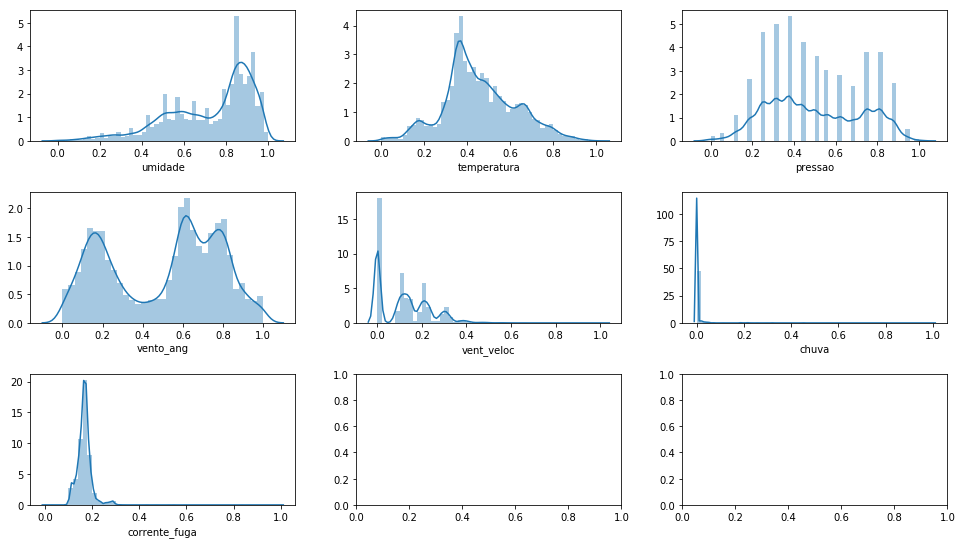

In [13]:
distplots_dataframe(scaled_data)

In [14]:
# Dados estatísticos do dataframe
df = scaled_data
df.describe()

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
count,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000
mean,0.726673,0.456358,0.495887,0.503842,0.120464,0.003483,0.167389
std,0.201368,0.166669,0.223528,0.278183,0.111802,0.027008,0.030226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.578125,0.351064,0.312500,0.210084,0.000000,0.000000,0.152262
50%,0.796875,0.430851,0.437500,0.588235,0.117647,0.000000,0.167479
75%,0.890625,0.563830,0.687500,0.742297,0.201681,0.000000,0.179329
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Verificando outliers no modelo

In [15]:
def boxplots_dataframe(df_analisado):
    fig, ax = plt.subplots(2, 3, figsize=(14,8))
    fig.tight_layout(pad=3.0)

    ax[0,0].boxplot(df_analisado.umidade)
    ax[0,1].boxplot(df_analisado.temperatura)
    ax[0,2].boxplot(df_analisado.pressao)
    ax[1,0].boxplot(df_analisado.vento_ang)
    ax[1,1].boxplot(df_analisado.vent_veloc)
    ax[1,2].boxplot(df_analisado.chuva)

    ax[0,0].set_title('Umidade')
    ax[0,1].set_title('Temperatura')
    ax[0,2].set_title('Pressão')
    ax[1,0].set_title('Ângulo do vento')
    ax[1,1].set_title('Velocidade do vento')
    ax[1,2].set_title('Chuva (mm)')

    plt.show()

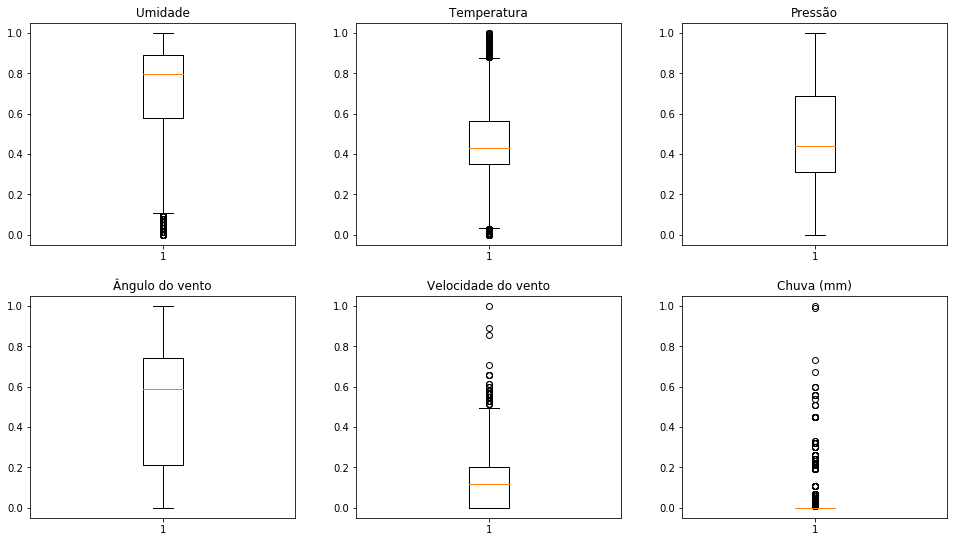

In [16]:
boxplots_dataframe(df)

In [17]:
# Plotando a correlação entre os atributos
df.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,umidade,temperatura,pressao,vento_ang,vent_veloc,chuva,corrente_fuga
umidade,1.0,-0.44157,-0.20368,0.32259,-0.50396,0.11214,0.69658
temperatura,-0.44157,1.0,-0.39874,-0.43925,0.45762,-0.11037,-0.34919
pressao,-0.20368,-0.39874,1.0,-0.011539,-0.045943,0.044076,-0.064254
vento_ang,0.32259,-0.43925,-0.011539,1.0,-0.34307,0.0424,0.22667
vent_veloc,-0.50396,0.45762,-0.045943,-0.34307,1.0,-0.0043842,-0.3078
chuva,0.11214,-0.11037,0.044076,0.0424,-0.0043842,1.0,0.29679
corrente_fuga,0.69658,-0.34919,-0.064254,0.22667,-0.3078,0.29679,1.0


In [18]:
# Correlação da corrente de fuga com os demais atributos.
df.corr()['corrente_fuga']

umidade          0.696576
temperatura     -0.349192
pressao         -0.064254
vento_ang        0.226674
vent_veloc      -0.307804
chuva            0.296792
corrente_fuga    1.000000
Name: corrente_fuga, dtype: float64

#### Preparação dos dados para o modelo

Apesar do atributo chuva possuir muitos registros com valor zero, e da baixa correlação da pressão, os dois atributos serão mantidos para a criação do modelo base.

In [19]:
colunas = df.columns.drop(['corrente_fuga'])

#### Criando os modelos de machine learning

##### 01. Regressão Linear

**Função para cálculo do *score* na *Regressão Linear***

In [20]:
def calcula_regressao(columns):
    X_train, X_test, y_train, y_test = train_test_split(df[columns], df['corrente_fuga'], test_size=0.20, random_state=42)
    lr = LinearRegression(normalize = False, fit_intercept=True)
    # Treinando o modelo
    model_lr = lr.fit(X_train, y_train)
    result_lr = model_lr.predict(X_test)
    # MSE: média do erro quadrado. Quanto menor o valor, mais acertivo é o modelo.
    mse_lr = mean_squared_error(y_test, result_lr)
    # RMSE: raiz quadrada do MSE (facilita a visualização do valor).
    rmse_lr = (np.sqrt(mse_lr))
    # A métrica score varia entre 0 e 1, e indica percentualmente o quanto o modelo consegue explicar os valores observados.
    # Quanto maior o valor mais explicativo é o modelo.
    score_lr = model_lr.score(X_test, y_test)
    print('Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:\n  MSE: {}'.format(mse_lr) 
          + '\n RMSE: {}'.format(rmse_lr) 
          + '\nScore: {:2.4f}'.format(score_lr * 100) + '%')
    return score_lr;

**Calculando o erro e computando o *score* para os dados de teste, removendo apenas a coluna *target*.**

In [21]:
# Excluindo a variável target 'corrente_fuga'.
cols = df.columns.drop(['corrente_fuga'])
cols

Index(['umidade', 'temperatura', 'pressao', 'vento_ang', 'vent_veloc',
       'chuva'],
      dtype='object')

In [22]:
score_cols = calcula_regressao(cols)

Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:
  MSE: 0.0003483160762296319
 RMSE: 0.01866322791560002
Score: 58.1681%


###### Manipulando colunas para comparar os scores

**Removendo colunas com correlação menor que 0.50.**

In [23]:
cols_maior_05 = df.columns.drop(['temperatura','pressao','vento_ang','vent_veloc','chuva','corrente_fuga'])
cols_maior_05

Index(['umidade'], dtype='object')

In [24]:
score_cols_maior_05 = calcula_regressao(cols_maior_05)

Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:
  MSE: 0.00038852908063290485
 RMSE: 0.019711141028182638
Score: 53.3386%


**Removendo colunas com correlação menor que 0.30.**

In [25]:
cols_maior_03 = df.columns.drop(['pressao', 'vento_ang','chuva','corrente_fuga'])
cols_maior_03

Index(['umidade', 'temperatura', 'vent_veloc'], dtype='object')

In [26]:
score_cols_maior_03 = calcula_regressao(cols_maior_03)

Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:
  MSE: 0.000381501960400874
 RMSE: 0.01953207516883124
Score: 54.1825%


**Removendo colunas com correlação menor que 0.10.**

In [27]:
cols_maior_01 = df.columns.drop(['pressao','corrente_fuga'])
cols_maior_01

Index(['umidade', 'temperatura', 'vento_ang', 'vent_veloc', 'chuva'], dtype='object')

In [28]:
score_cols_maior_01 = calcula_regressao(cols_maior_01)

Resultados do erro médio e score (acurácia do modelo) para o dataset de teste:
  MSE: 0.0003520772139388396
 RMSE: 0.01876372068484392
Score: 57.7164%


**Comparando os *scores* dos quatro modelos testados.**

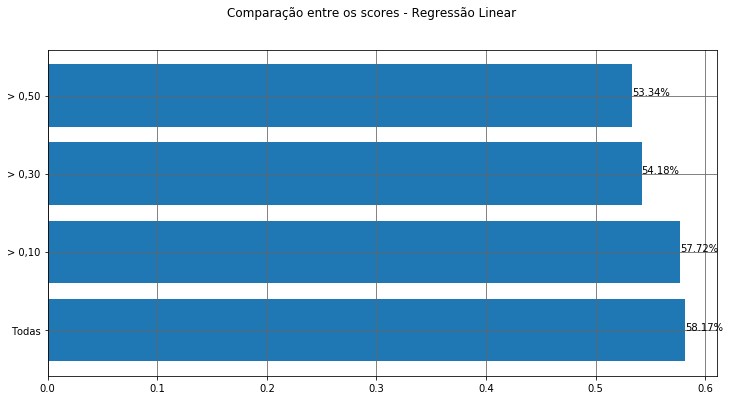

In [52]:
scores = [score_cols, score_cols_maior_01, score_cols_maior_03, score_cols_maior_05]
labels = ['Todas', '> 0,10', '> 0,30', '> 0,50']

fig, ax = plt.subplots(1, figsize=(12,6))
fig.suptitle('Comparação entre os scores - Regressão Linear')

ax.barh(labels, scores)
plt.grid(b=True, which='major', color='#666666', linestyle='-')

for index, score in enumerate(scores):
    plt.text(score, index, str('{:2.2f}'.format(score * 100) + '%'))

plt.show()

Na **Regressão Linear** tivemos um melhor *score* mantendo todas as colunas.  
Iremos manter todas as colunas para os testes com outros *algoritmos*.

##### 02. Árvore de Decisão

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df[colunas], df['corrente_fuga'], test_size=0.20, random_state=42)

In [31]:
tree = DecisionTreeRegressor()

In [32]:
model_tree = tree.fit(X_train, y_train)
result_tree = tree.predict(X_test)

In [33]:
mse_tree = mean_squared_error(y_test, result_tree)
rmse_tree = (np.sqrt(mse_tree))
score_tree = model_tree.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_tree) 
      + '\n RMSE: {}'.format(rmse_tree) 
      + '\nScore: {:2.3f}'.format(score_tree * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 0.0001863738667505921
 RMSE: 0.01365188143629266
Score: 77.617%


##### 03. Random Forest

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df[colunas], df['corrente_fuga'], test_size=0.20, random_state=42)

In [35]:
tree_rf = RandomForestRegressor()

In [36]:
model_rf = tree_rf.fit(X_train, y_train)
result_rf = model_rf.predict(X_test)

In [37]:
mse_rf = mean_squared_error(y_test, result_rf)
rmse_rf = (np.sqrt(mse_rf))
score_rf = model_rf.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_rf) 
      + '\n RMSE: {}'.format(rmse_rf) 
      + '\nScore: {:2.3f}'.format(score_rf * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 0.00010448218007221088
 RMSE: 0.010221652511810939
Score: 87.452%


##### 04. Random Forest com ajustes nos hiperparâmetros

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[colunas], df['corrente_fuga'], test_size=0.20, random_state=42)

In [39]:
param = {'min_samples_leaf':[1,3,5],'min_samples_split':[2,3,5],'n_estimators':[50,150,250]}
rf = RandomForestRegressor()
grid = GridSearchCV(rf, param, n_jobs=4)

In [40]:
# Executando o grid
grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_leaf': [1, 3, 5], 'min_samples_split': [2, 3, 5], 'n_estimators': [50, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
# Verificando os melhores parâmetros
grid.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 250}

In [42]:
rf_best = grid.best_estimator_
print(rf_best)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [43]:
result_grid = rf_best.predict(X_test)

In [44]:
mse_grid = mean_squared_error(y_test, result_grid)
rmse_grid = (np.sqrt(mse_grid))
score_grid = rf_best.score(X_test, y_test)
print('Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:\n  MSE: {}'.format(mse_grid) 
      + '\n RMSE: {}'.format(rmse_grid) 
      + '\nScore: {:2.3f}'.format(score_grid * 100) + '%')

Resultados do erro médio e score (acurácia do modelo) para o dataset de treino:
  MSE: 8.251287486336967e-05
 RMSE: 0.009083659772545957
Score: 90.090%


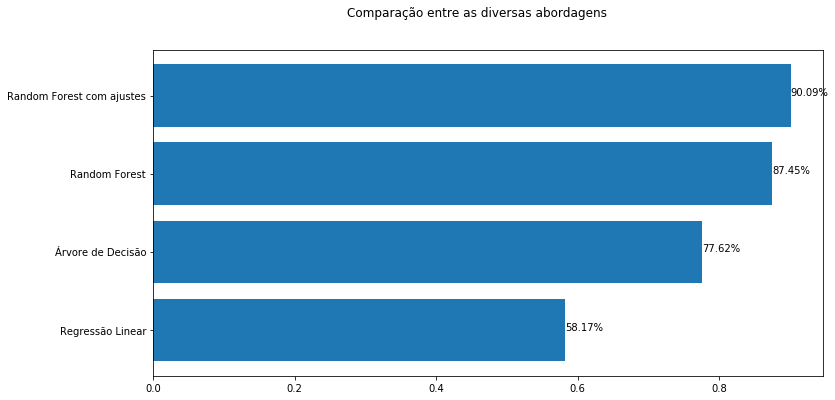

In [45]:
scores = [score_cols, score_tree, score_rf, score_grid]
labels = ['Regressão Linear', 'Árvore de Decisão', 'Random Forest', 'Random Forest com ajustes']

fig, ax = plt.subplots(1, figsize=(12,6))
fig.suptitle('Comparação entre as diversas abordagens')

ax.barh(labels, scores)
#plt.grid(b=True, which='major', color='#666666', linestyle='-')

for index, score in enumerate(scores):
    plt.text(score, index, str('{:2.2f}'.format(score * 100) + '%'))

plt.show()

##### Comparação dos valores atuais e previstos

In [46]:
df_comparacao = pd.DataFrame({'Atual': y_test, 'Previsto': result_grid})
df_comparacao.head(10)

,Atual,Previsto
4943,0.180253,0.175453
30083,0.201466,0.202456
25353,0.177424,0.178007
26959,0.183708,0.184582
18264,0.181854,0.179802
19244,0.164301,0.168584
30002,0.197662,0.199776
39360,0.160629,0.165030
2265,0.174859,0.175861
34139,0.129026,0.137641


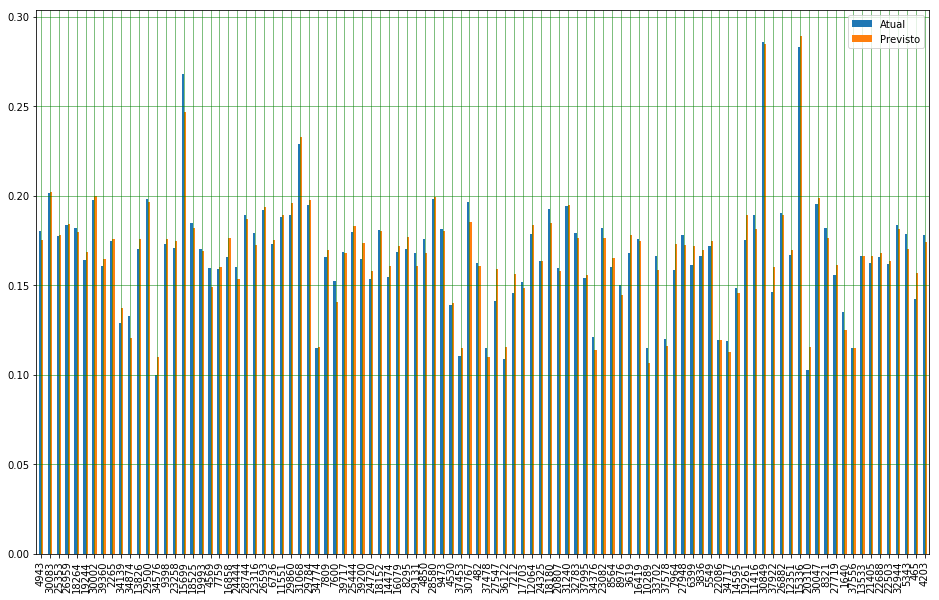

In [51]:
df1 = df_comparacao.head(100)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.show()